<a href="https://colab.research.google.com/github/14gabe14/LC-GRIND/blob/main/data_analysis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
np.random.seed(seed=42)

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

<ipython-input-7-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


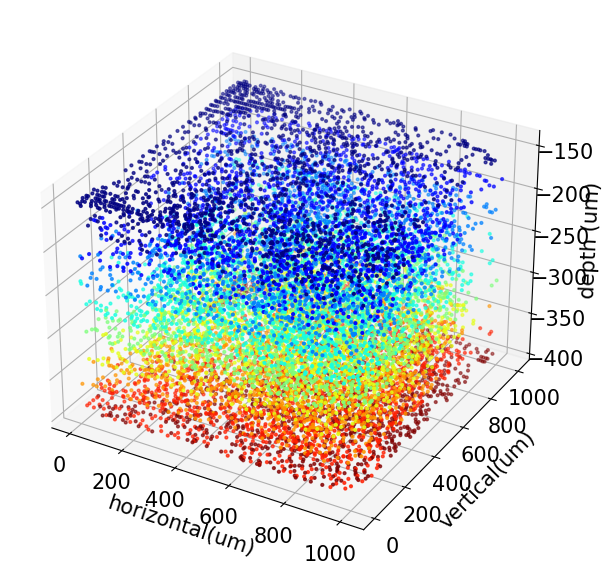

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

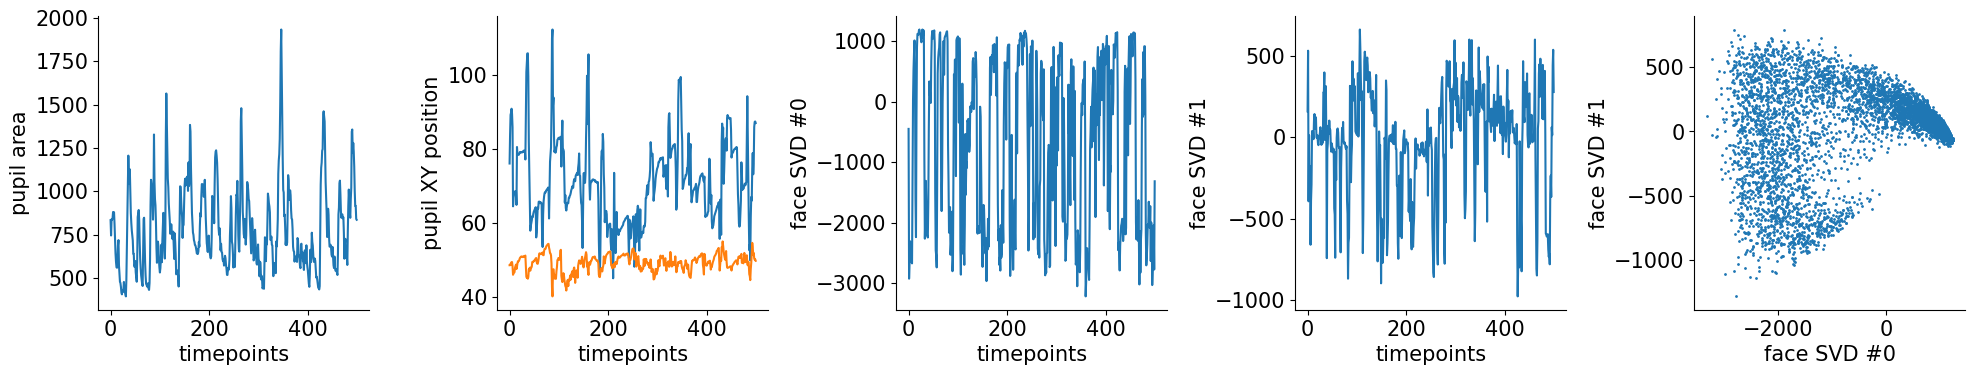

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

sresp: (11983, 7018)
run: (7018, 1)
beh_svd_time: (7018, 1000)
beh_svd_mask: (240, 320, 1000)
stat: (11983, 1)
pupilArea: (7018, 1)
pupilCOM: (7018, 2)
xyz: (3, 11983)


[Text(0.5, 0, 'timebins'),
 Text(0, 0.5, 'Position'),
 Text(0.5, 1.0, 'Pupil X and Y Position over time')]

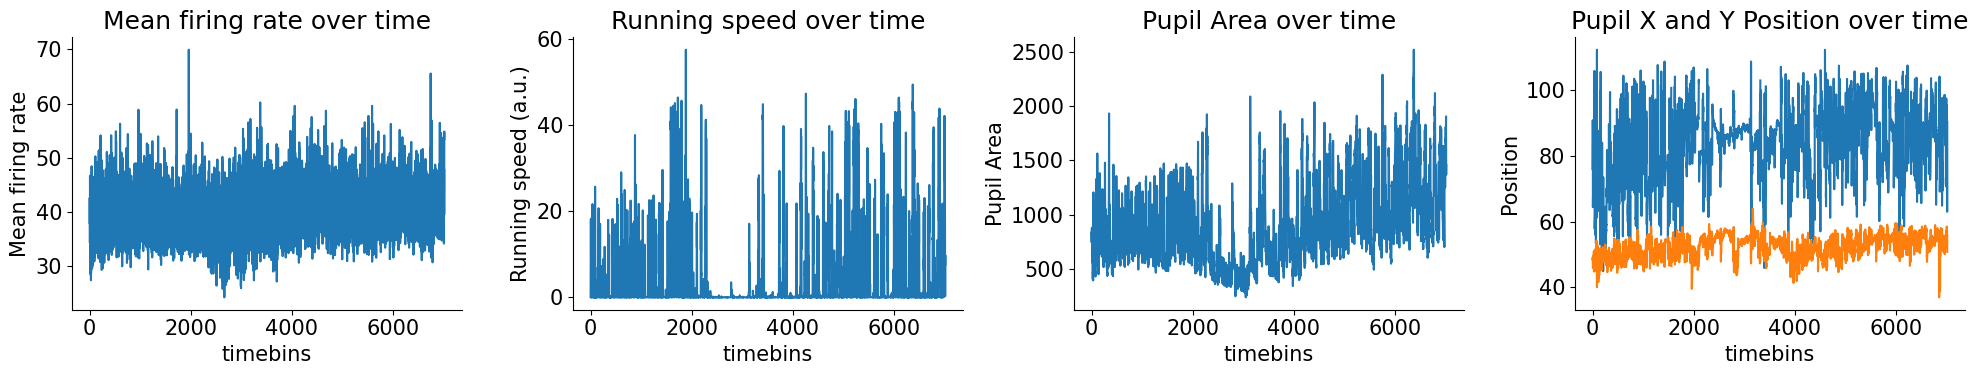

In [ ]:
# @title Data Exploration

# Let's assume 'dat' is your data dictionary

# Basic data exploration
for key in dat.keys():
    print(f"{key}: {dat[key].shape}")

# Neural response data - 'sresp'
# Calculate and plot the mean firing rate across all neurons
mean_firing_rate = dat['sresp'].mean(axis=0)
ax = plt.subplot(1, 4, 1)
plt.plot(mean_firing_rate)
ax.set(xlabel='timebins', ylabel='Mean firing rate', title='Mean firing rate over time')

"""
neuron 1 [1, 2, 3]
neuron 2 [4, 5, 9]
"""

# Running speed - 'run'
# Plot running speed over time
ax = plt.subplot(1, 4, 2)
# plt.figure(figsize=(10, 6))
plt.plot(dat['run'])
ax.set(xlabel='timebins', ylabel='Running speed (a.u.)', title='Running speed over time')

# Pupil area - 'pupilArea'
# Plot pupil area over time
ax = plt.subplot(1, 4, 3)
plt.plot(dat['pupilArea'])
ax.set(xlabel='timebins', ylabel='Pupil Area', title='Pupil Area over time')


# Pupil center of mass - 'pupilCOM'
# Plot pupil X and Y position over time
ax = plt.subplot(1, 4, 4)
plt.plot(dat['pupilCOM'][:, 0], label='X position')
plt.plot(dat['pupilCOM'][:, 1], label='Y position')
ax.set(xlabel='timebins', ylabel='Position', title='Pupil X and Y Position over time')

# More complex explorations can be made for the other variables. For example, 'beh_svd_time'
# and 'beh_svd_mask' could be used to explore changes in facial behavior over time.


In [ ]:
# @title K-means

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
sresp_norm = scaler.fit_transform(dat['sresp'])

# Fit KMeans
kmeans = KMeans(n_clusters=6, random_state=0)  # Set number of clusters as required
clusters = kmeans.fit_predict(sresp_norm)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Correlation between cluster 0 and running speed: -0.16445900923800794
Valor p para 0: 9.710483472560435e-44
Correlation between cluster 1 and running speed: -0.35731459678561106
Valor p para 1: 2.1241458841370193e-210
Correlation between cluster 2 and running speed: -0.2756209189962101
Valor p para 2: 1.4780285668666727e-122
Correlation between cluster 3 and running speed: -0.08465817167835882
Valor p para 3: 1.2154555699677424e-12
Correlation between cluster 4 and running speed: 0.7638615693278991
Valor p para 4: 0.0
Correlation between cluster 5 and running speed: 0.12642316233669512
Valor p para 5: 2.1219444914065008e-26


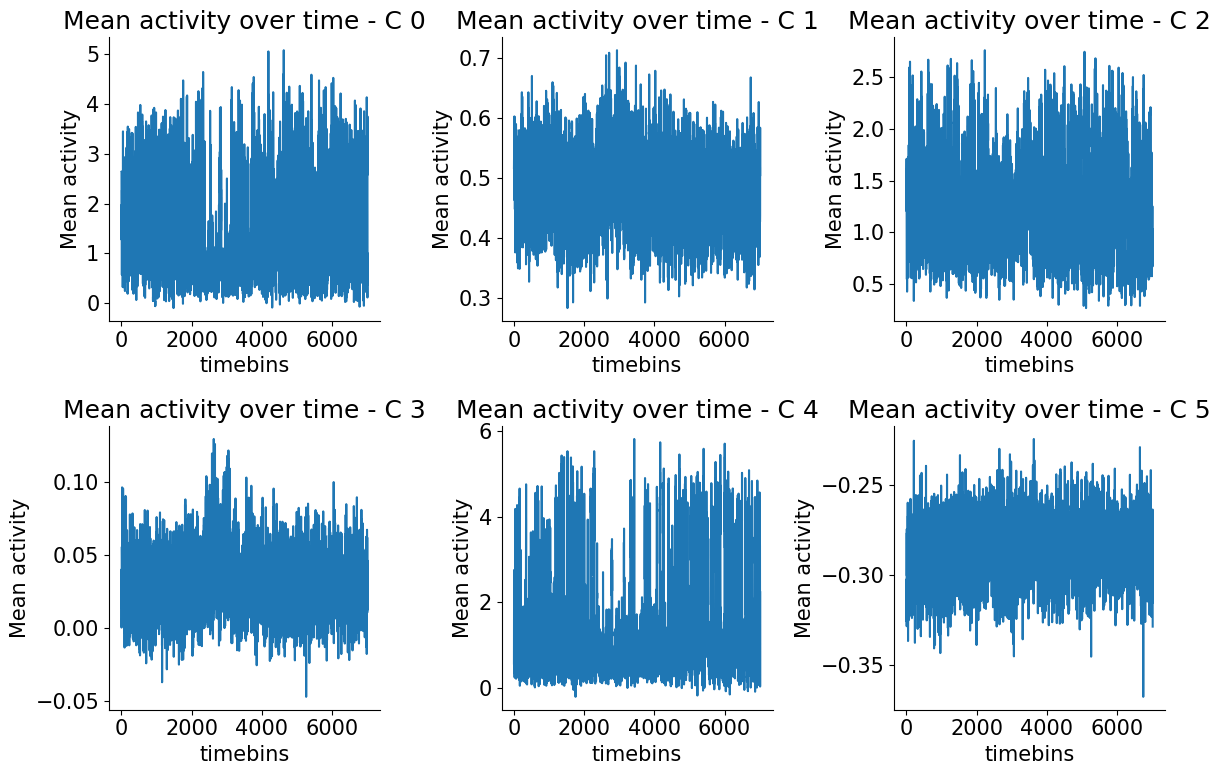

In [ ]:
# @title

from scipy.stats import pearsonr

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(6):  # For each cluster
    cluster_neurons = sresp_norm[clusters == i]
    mean_activity = np.mean(cluster_neurons, axis=0)
    correlation, p_value = pearsonr(mean_activity, dat['run'].ravel())
    print(f"Correlation between cluster {i} and running speed: {correlation}")
    print(f"Valor p para {i}:", p_value)

    ax = axes[i//3, i%3]
    ax.plot(mean_activity)
    ax.set(xlabel='timebins', ylabel='Mean activity', title=f'Mean activity over time - C {i}')


In [ ]:
dat['xyz'].shape

(3, 11983)

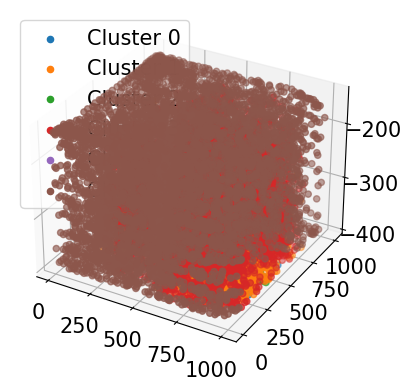

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(6):  # For each cluster

    cluster_neurons = sresp_norm[clusters == i]
    neuron_indexes = np.where(clusters == i)[0]
    cluster_neurons_xyz = dat['xyz'][:, neuron_indexes]
    ax.scatter(cluster_neurons_xyz[0, :], cluster_neurons_xyz[1, :], cluster_neurons_xyz[2, :], label=f'Cluster {i}')

ax.legend()
plt.show()

<ipython-input-13-4cf190dd0a07>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


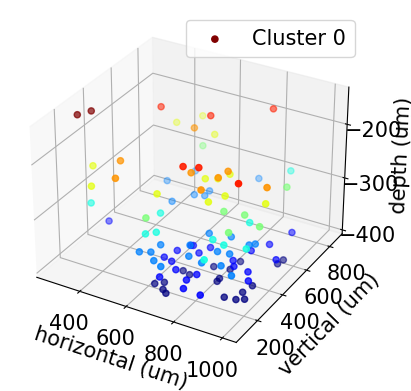

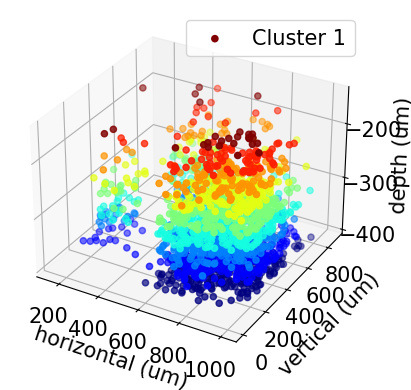

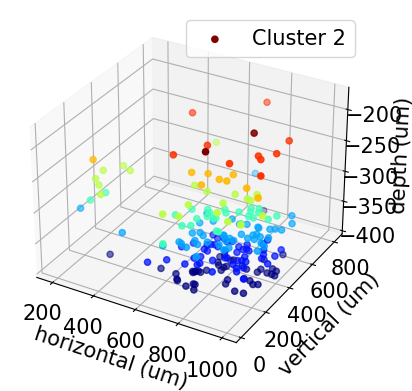

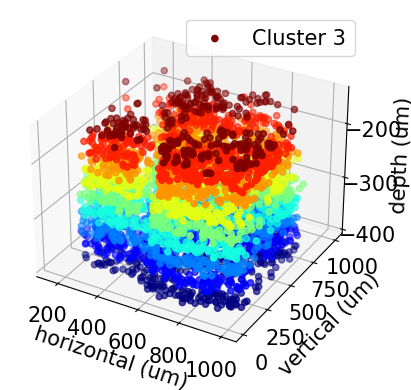

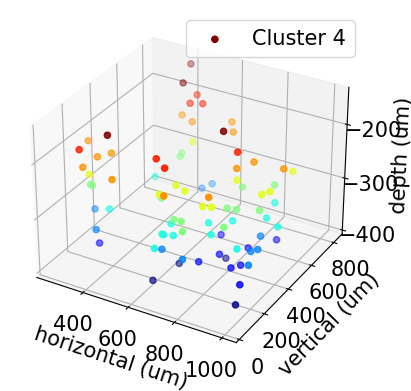

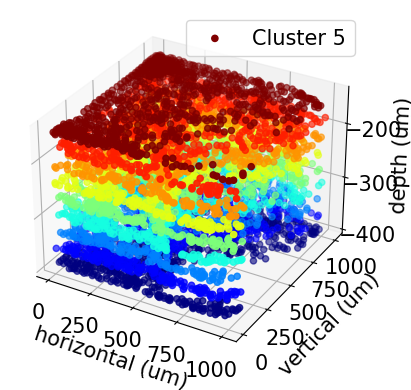

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for i in range(6):  # For each cluster
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cluster_neurons = sresp_norm[clusters == i]
    neuron_indexes = np.where(clusters == i)[0]
    cluster_neurons_xyz = dat['xyz'][:, neuron_indexes]

    zunq, iunq = np.unique(cluster_neurons_xyz[2, :], return_inverse=True)
    xc = np.linspace(0.0, 1.0, len(zunq))
    cmap = cm.get_cmap('jet')(xc)

    ax.scatter(cluster_neurons_xyz[0, :], cluster_neurons_xyz[1, :], cluster_neurons_xyz[2, :], c=cmap[iunq], label=f'Cluster {i}')

    ax.legend()
    ax.set_xlabel('horizontal (um)')
    ax.set_ylabel('vertical (um)')
    ax.set_zlabel('depth (um)')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
sresp_pca = pca.fit_transform(sresp_norm)

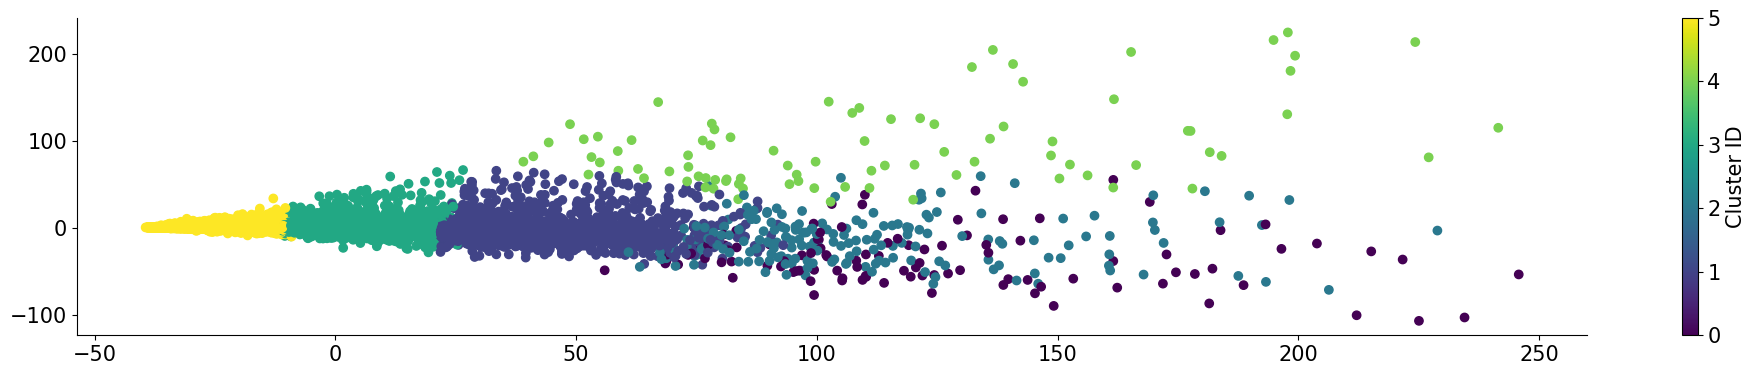

In [ ]:
plt.scatter(sresp_pca[:, 0], sresp_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label='Cluster ID')  # If you want a colorbar to show the cluster IDs
plt.show()

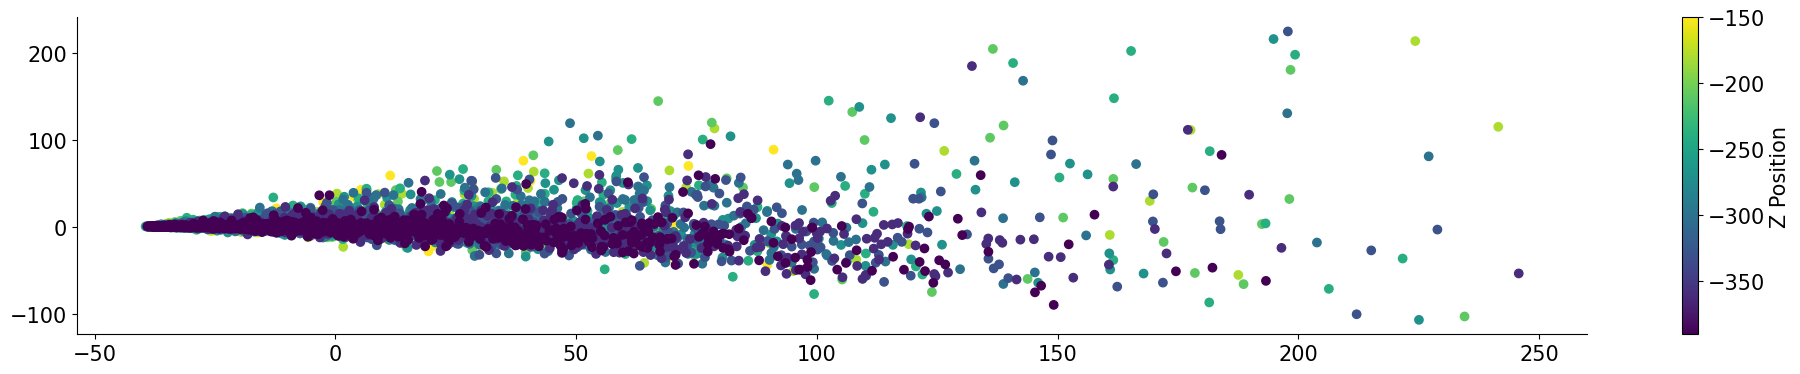

In [ ]:
plt.scatter(sresp_pca[:, 0], sresp_pca[:, 1], c=dat['xyz'][2,:], cmap='viridis')
plt.colorbar(label='Z Position')  # If you want a colorbar to show the z positions
plt.show()

In [ ]:
pca = PCA(n_components=3)  # Reduce to 3 dimensions for visualization
sresp_pca = pca.fit_transform(sresp_norm)

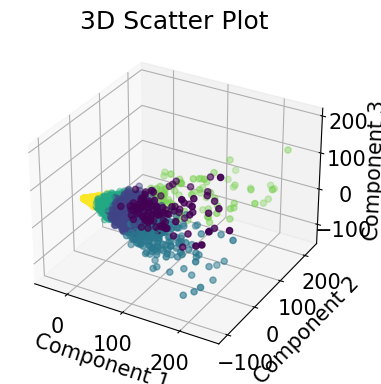

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting functionality
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')  # Creating a 3D subplot

ax.scatter(sresp_pca[:, 0], sresp_pca[:, 1], sresp_pca[:, 2], c=clusters, cmap='viridis')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D Scatter Plot')

plt.show()


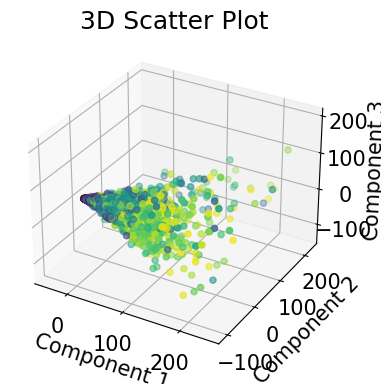

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting functionality
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')  # Creating a 3D subplot

ax.scatter(sresp_pca[:, 0], sresp_pca[:, 1], sresp_pca[:, 2], c=dat['xyz'][0, :], cmap='viridis')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D Scatter Plot')

plt.show()

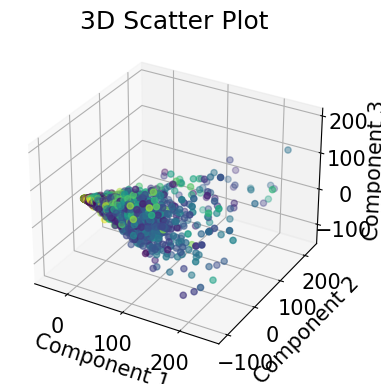

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting functionality
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')  # Creating a 3D subplot

ax.scatter(sresp_pca[:, 0], sresp_pca[:, 1], sresp_pca[:, 2], c=dat['xyz'][1, :], cmap='viridis')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D Scatter Plot')

plt.show()

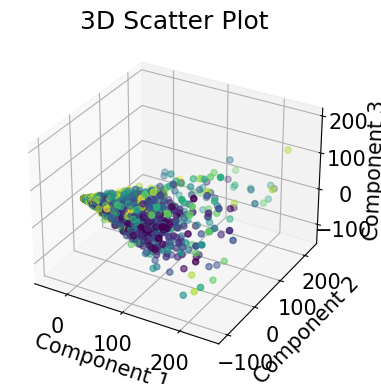

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting functionality
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')  # Creating a 3D subplot

ax.scatter(sresp_pca[:, 0], sresp_pca[:, 1], sresp_pca[:, 2], c=dat['xyz'][2, :], cmap='viridis')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D Scatter Plot')

plt.show()

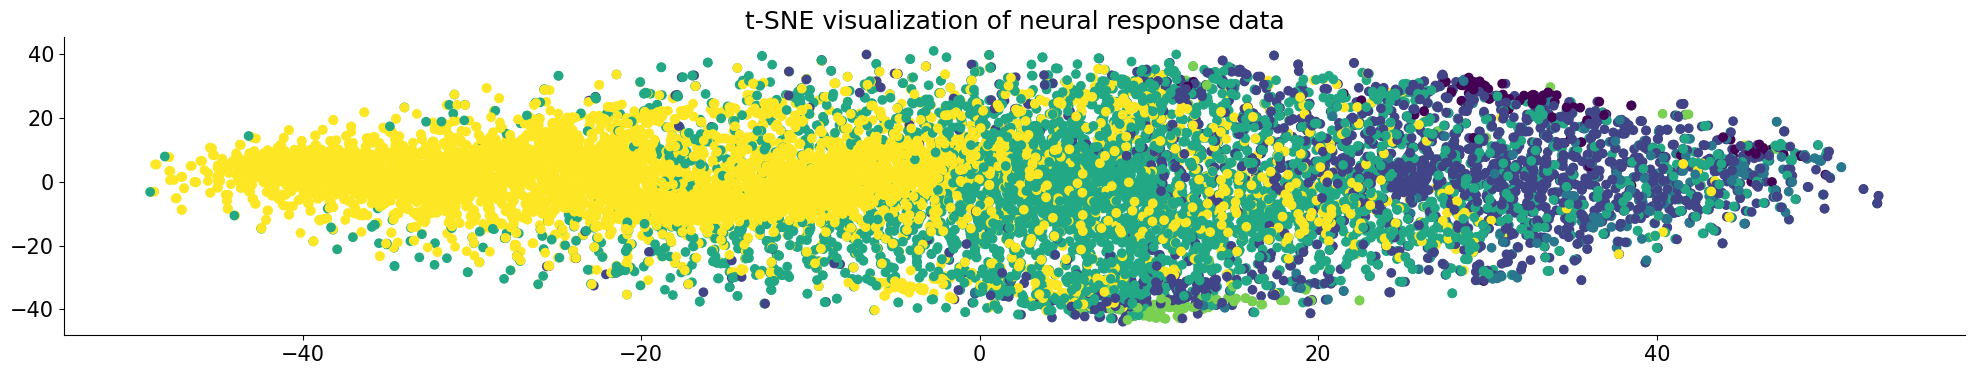

In [ ]:
from sklearn.manifold import TSNE

for i in range(10, 50, 10):
    # Instantiate a TSNE object
    tsne = TSNE(n_components=2, random_state=0, perplexity=i)  # Reduce to 2 dimensions for visualization

    # Normalize and apply t-SNE to the neural response data
    sresp_norm = StandardScaler().fit_transform(dat['sresp'])
    sresp_tsne = tsne.fit_transform(sresp_norm)

    # Plot the resulting 2D t-SNE representation
    plt.title('t-SNE visualization of neural response data')
    plt.scatter(sresp_tsne[:, 0], sresp_tsne[:, 1], c=clusters, cmap='viridis')
    plt.show()


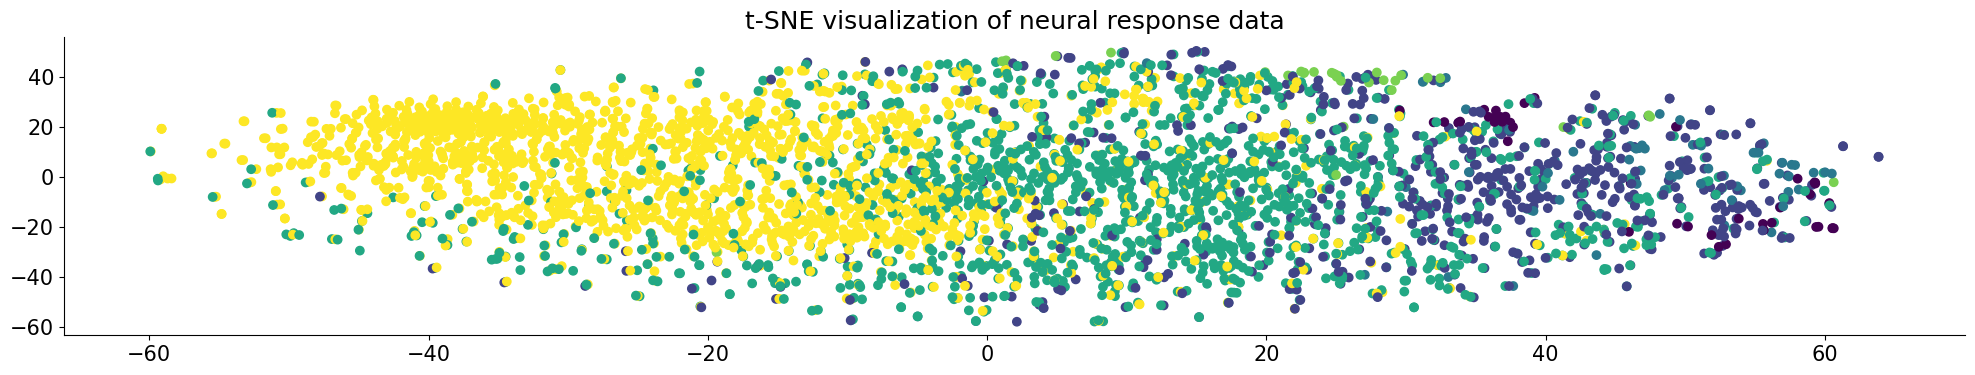

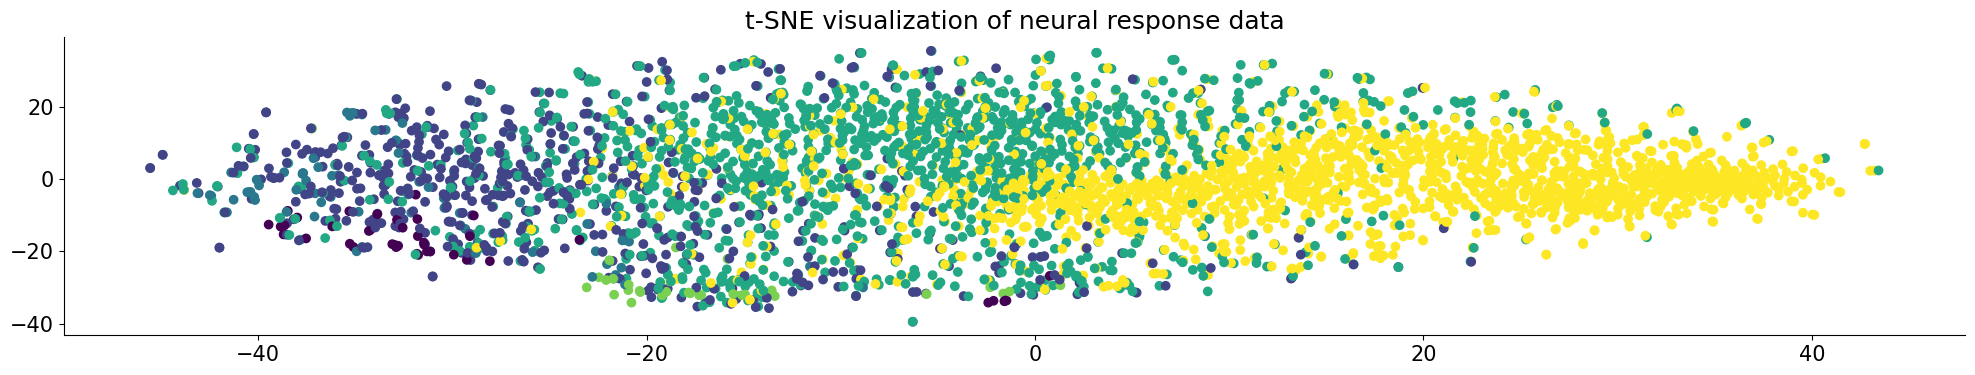

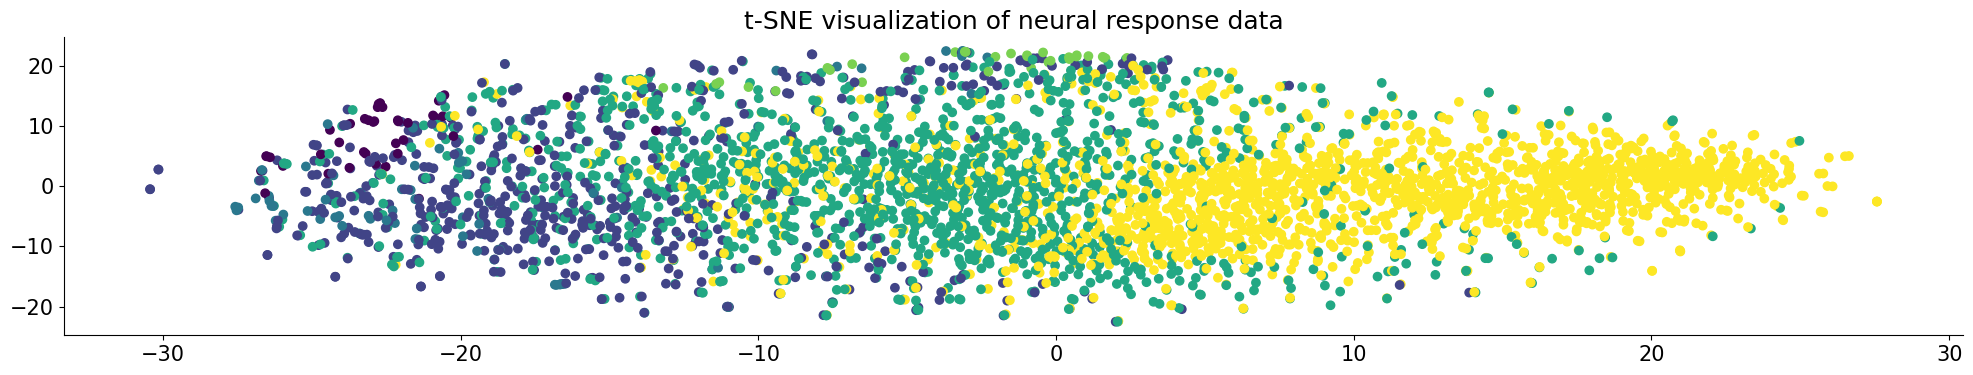

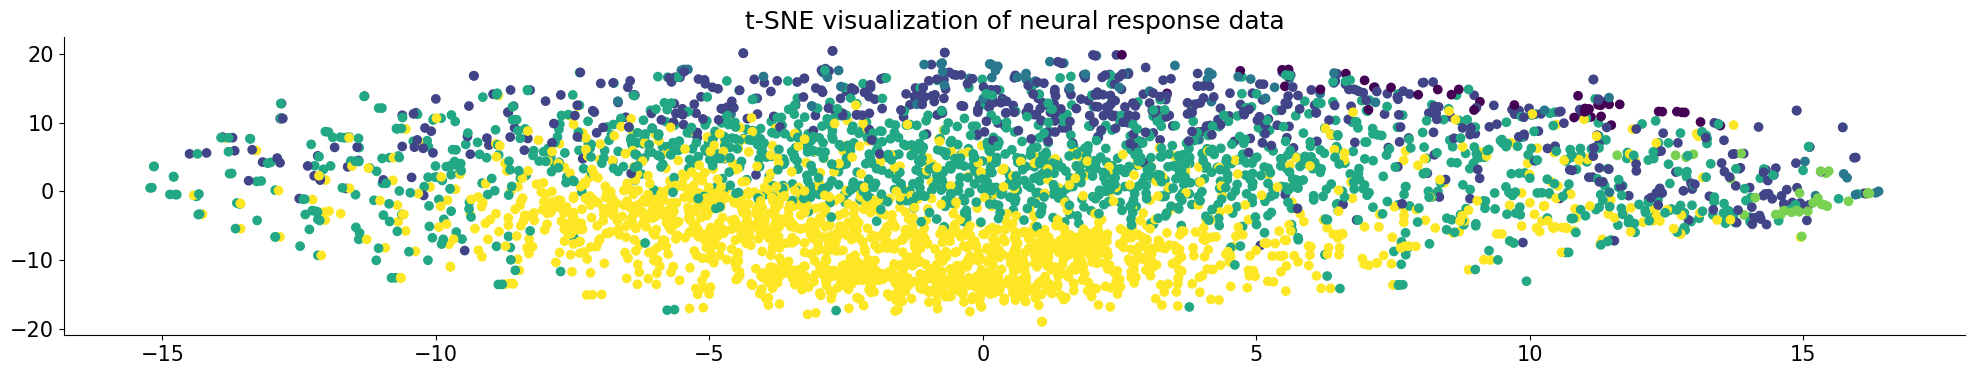

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Randomly select a third of the data
data = dat['sresp']
num_samples = len(data)
random_indices = np.random.choice(num_samples, size=num_samples//3, replace=False)
data_subset = data[random_indices]

for i in range(10, 50, 10):
    # Instantiate a TSNE object
    tsne = TSNE(n_components=2, random_state=0, perplexity=i)  # Reduce to 2 dimensions for visualization

    # Normalize and apply t-SNE to the neural response data subset
    sresp_norm = StandardScaler().fit_transform(data_subset)
    sresp_tsne = tsne.fit_transform(sresp_norm)

    # Plot the resulting 2D t-SNE representation
    plt.title('t-SNE visualization of neural response data')
    plt.scatter(sresp_tsne[:, 0], sresp_tsne[:, 1], c=clusters[random_indices], cmap='viridis')
    plt.show()


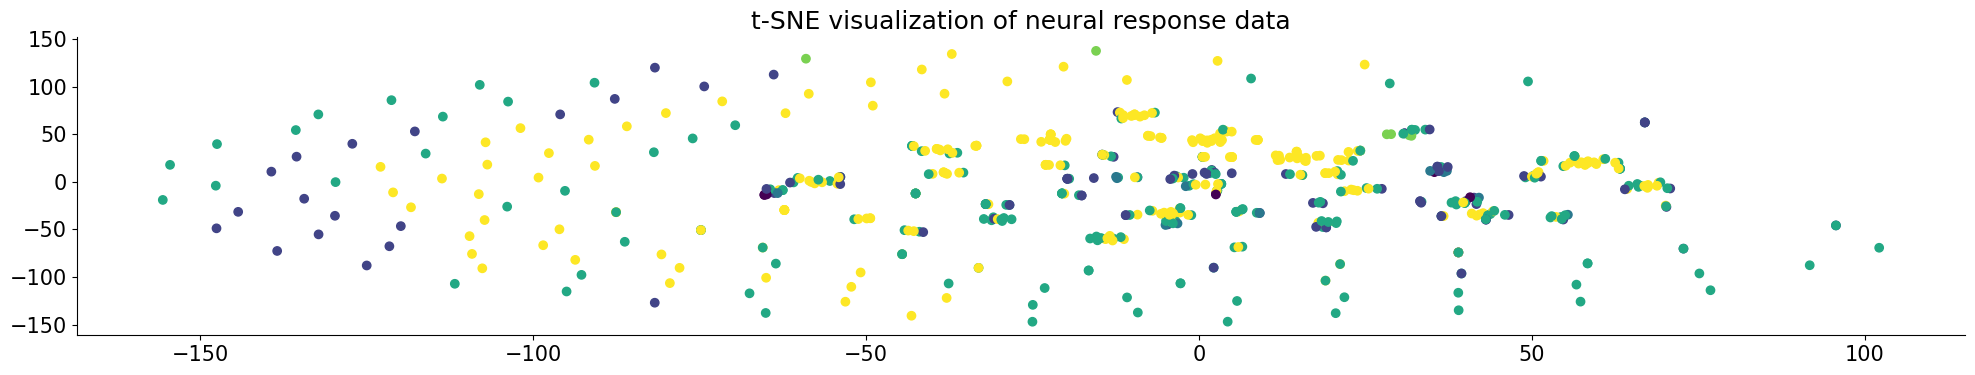

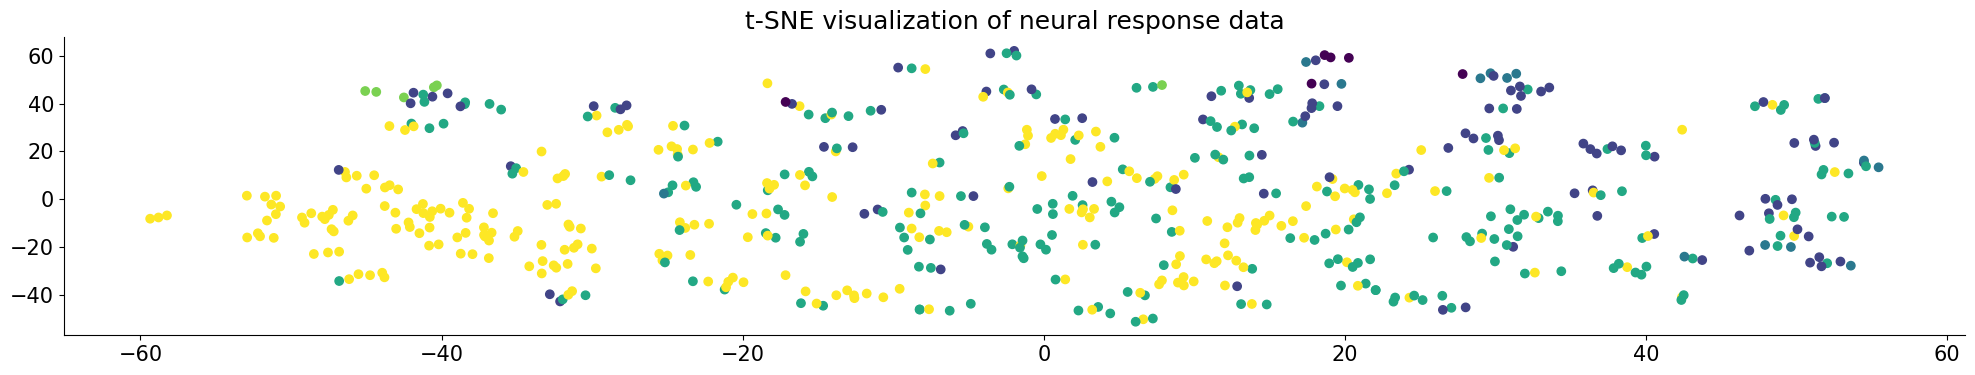

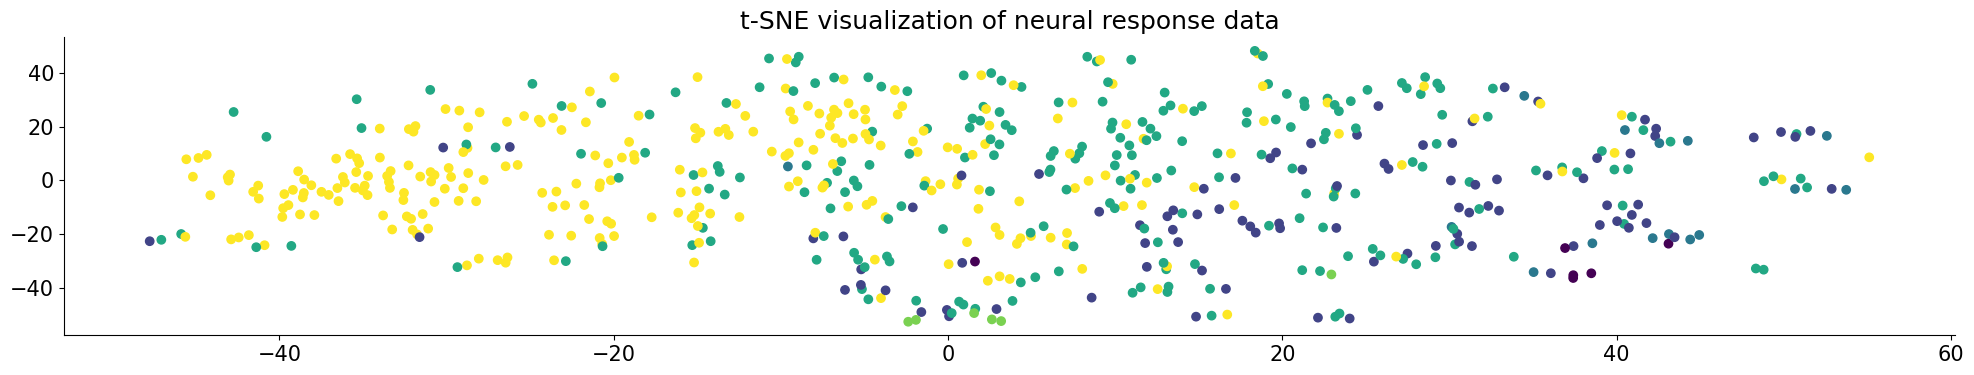

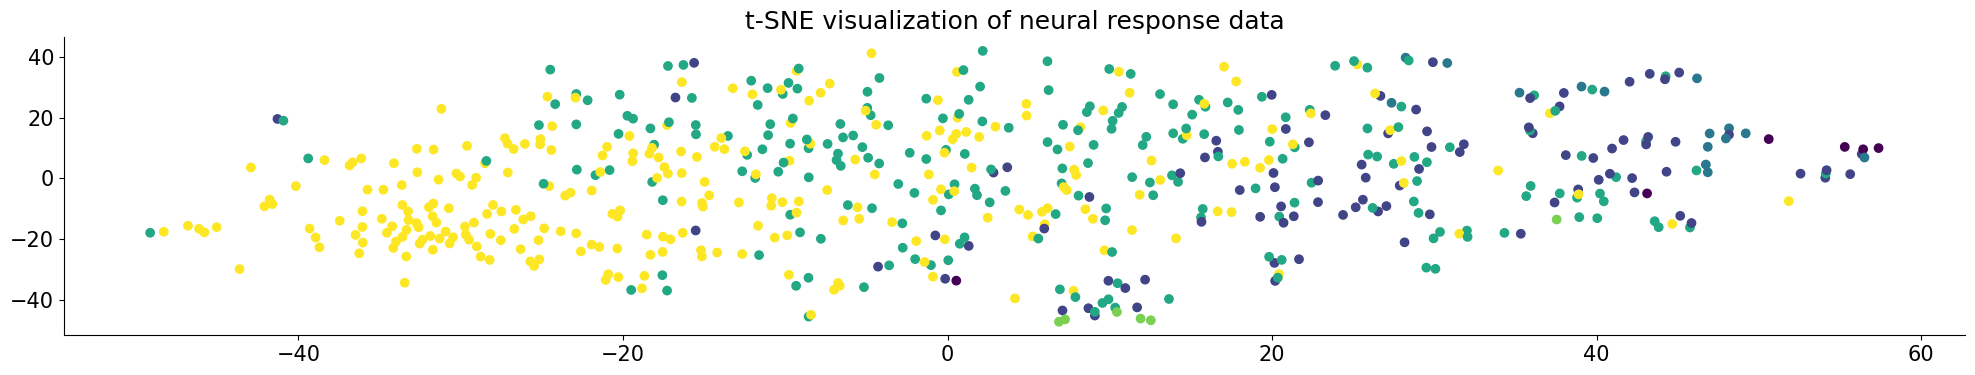

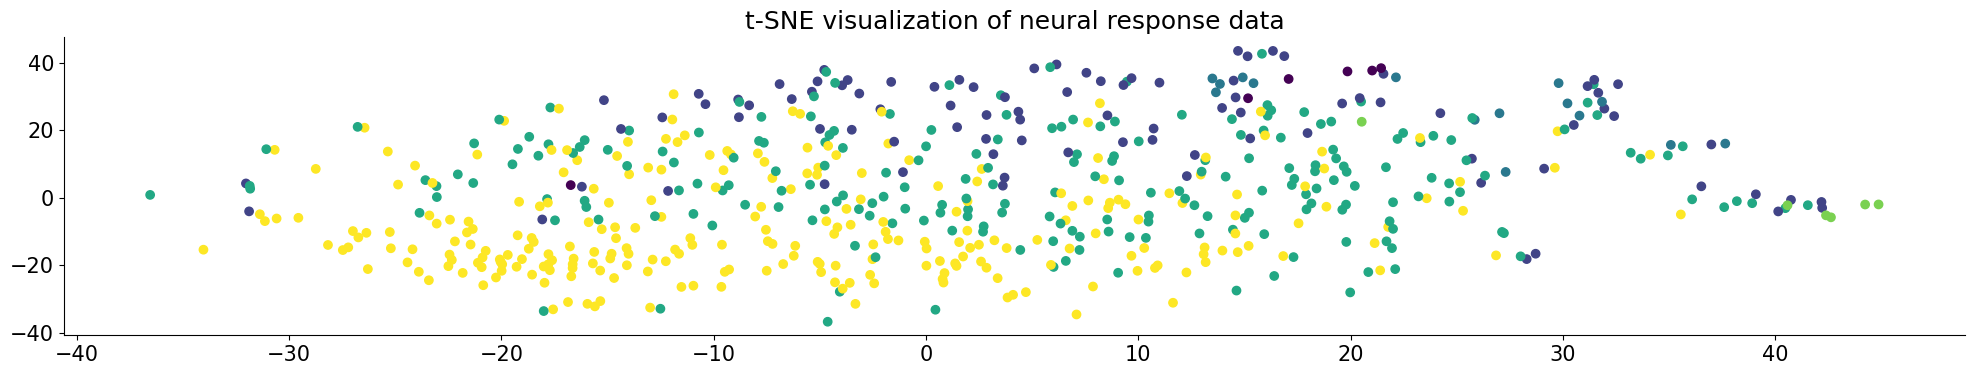

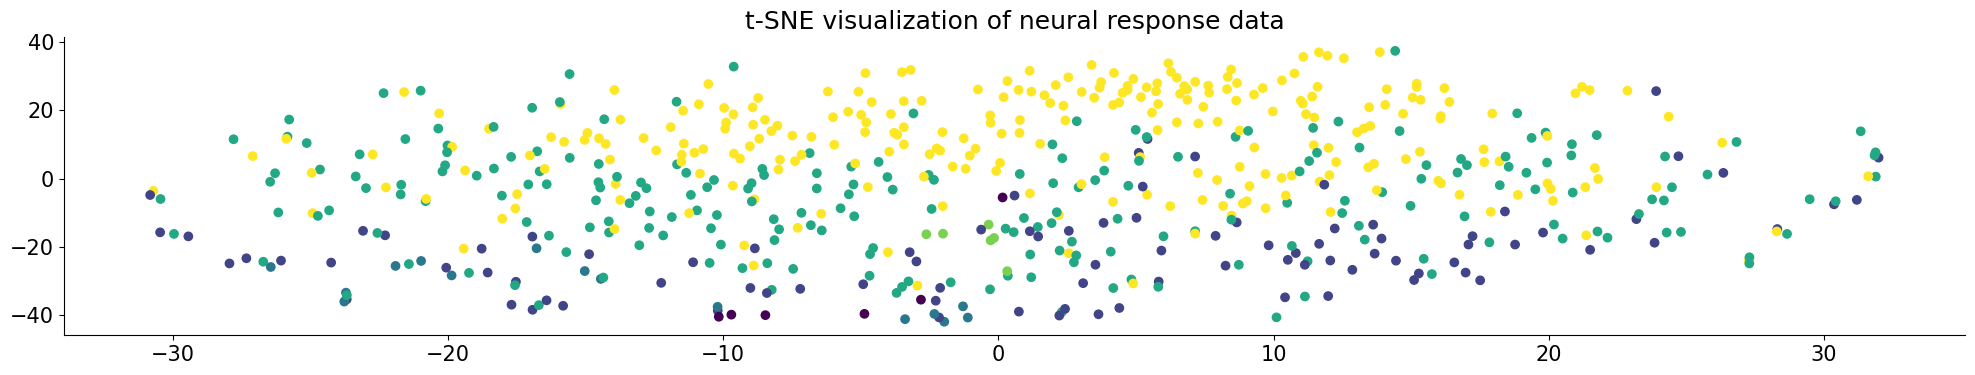

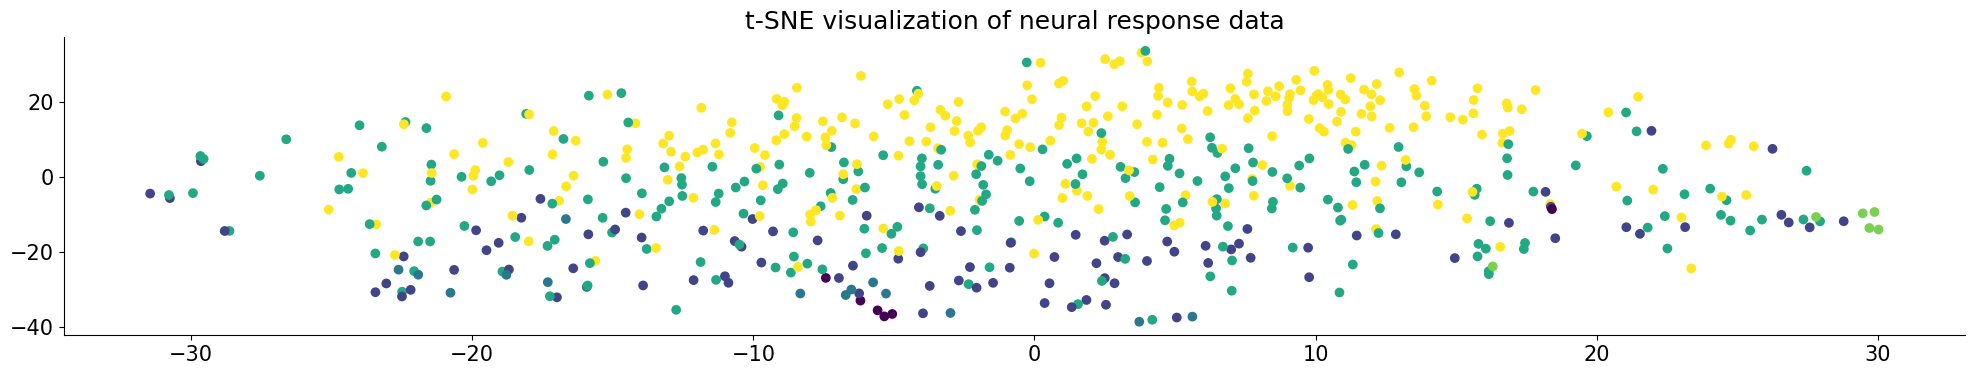

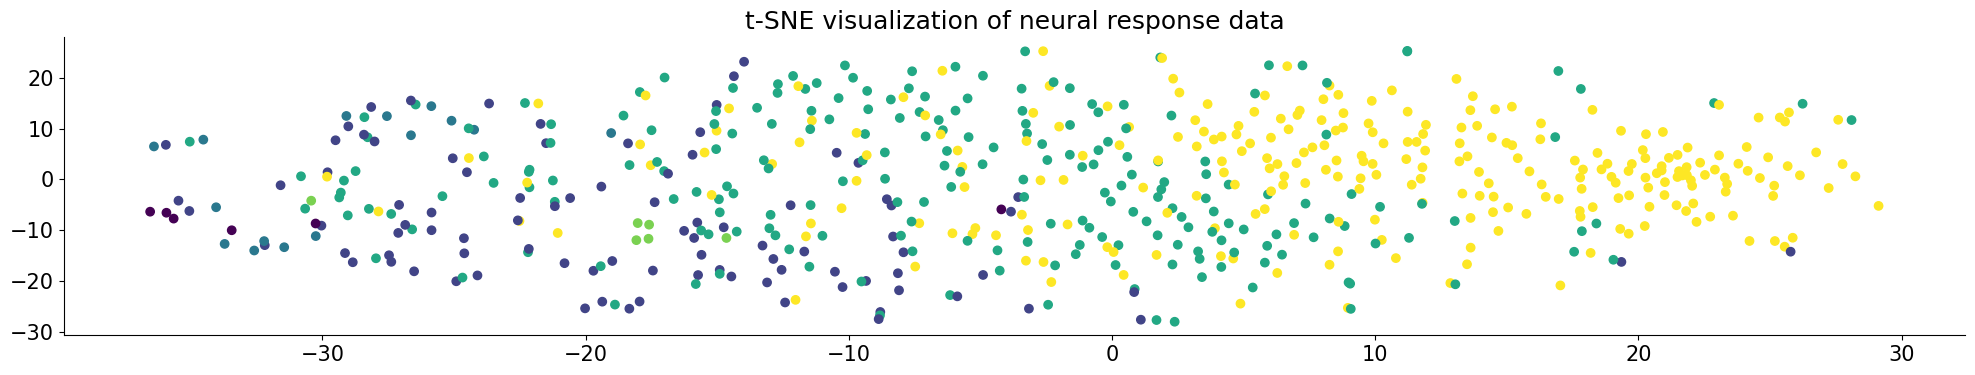

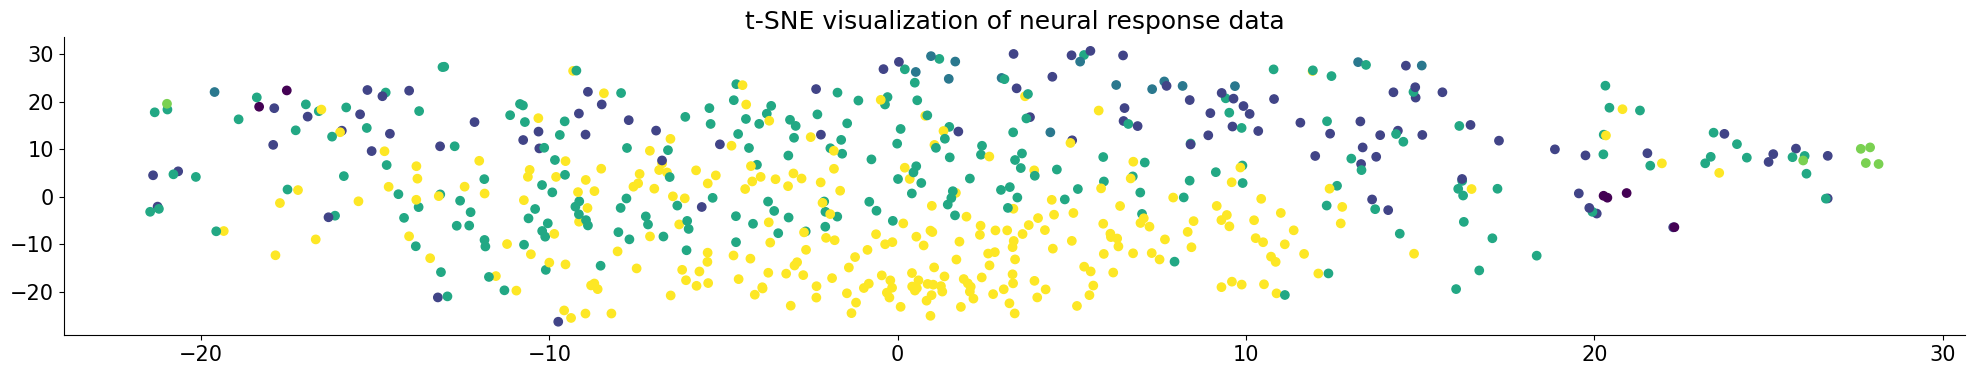

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Randomly select a third of the data
data = dat['sresp']
num_samples = len(data)
random_indices = np.random.choice(num_samples, size=num_samples//20, replace=False)
data_subset = data[random_indices]

for i in range(1, 10):
    # Instantiate a TSNE object
    tsne = TSNE(n_components=2, random_state=0, perplexity=i)  # Reduce to 2 dimensions for visualization

    # Normalize and apply t-SNE to the neural response data subset
    sresp_norm = StandardScaler().fit_transform(data_subset)
    sresp_tsne = tsne.fit_transform(sresp_norm)

    # Plot the resulting 2D t-SNE representation
    plt.title('t-SNE visualization of neural response data')
    plt.scatter(sresp_tsne[:, 0], sresp_tsne[:, 1], c=clusters[random_indices], cmap='viridis')
    plt.show()


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Randomly select a third of the data
data = dat['sresp']
num_samples = len(data)
random_indices = np.random.choice(num_samples, size=num_samples//3, replace=False)
data_subset = data[random_indices]

for i in range(10, 50, 10):
    # Instantiate a TSNE object
    tsne = TSNE(n_components=2, random_state=0, perplexity=i)  # Reduce to 2 dimensions for visualization

    # Normalize and apply t-SNE to the neural response data subset
    sresp_norm = StandardScaler().fit_transform(data_subset)
    sresp_tsne = tsne.fit_transform(sresp_norm)

    # Plot the resulting 2D t-SNE representation
    plt.title('t-SNE visualization of neural response data')
    plt.scatter(sresp_tsne[:, 0], sresp_tsne[:, 1], c=clusters[random_indices], cmap='viridis')
    plt.show()
